# NYC Policing Discrimination Study Showcase


#### In this showcase, we study whether stop and frisk policy was racially discriminatory, using NYPD stop and frisk data frecord. We will rely on logistic regression and regularized regression.


## Data processing

Read the CSV file "sqf_sample.csv" and filter for stops between 2009 and 2013 (including both 2009 and 2013 in your sample). Filter for stops of white, Black, Hispanic, and Asian pedestrians using the suspect_race column.


In [1]:
import pandas as pd
import numpy as np

sqf = pd.read_csv('sqf_sample.csv')

sqf_yr = sqf.loc[sqf['year'].isin([2009,2010,2011,2012,2013])]
sqf_yr = sqf_yr.loc[sqf_yr['suspect_race'].isin(['hispanic','asian','white','black'])]

## Frisk Decision Outcome using Regression.

We will start by testing for racial discrimination in the decision to conduct a frisk after a stop: ie, whether minority pedestrians are more likely to be frisked (patted down for weapons) after they are stopped, controlling for other factors.

Using statsmodels library, perform a logistic regressio using `frisked` as the dependent variable and `suspect_race` as the independent variable, to assess how the probability of being frisked after a stop varies by race.

In [2]:
import statsmodels.api as sm

x_train = pd.get_dummies(sqf_yr['suspect_race'])
y_train = sqf_yr['frisked']



log_reg = sm.Logit.from_formula('frisked ~ suspect_race',data=sqf_yr).fit()

print(log_reg.summary())
races = pd.unique(sqf_yr['suspect_race'])
print(races)


Optimization terminated successfully.
         Current function value: 0.681382
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                frisked   No. Observations:               249802
Model:                          Logit   Df Residuals:                   249798
Method:                           MLE   Df Model:                            3
Date:                Tue, 01 Nov 2022   Pseudo R-squ.:                0.005311
Time:                        18:58:37   Log-Likelihood:            -1.7021e+05
converged:                       True   LL-Null:                   -1.7112e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0900      0.022     -4.161      0.000      -0.132

Although those with Asian race data were present in data ('asian'), the logistic regression omitted them as coefficients. 
The value of the coefficient for each race represents their relative likelihood to be frisked in a stop, where value greater than 0 represents higher likelihood, and value less than 0 represents lower likelihood. 

In the other hand, Z values measures the statistical significance of findings. Greater absolute value of z indicates more significant and robust finding in terms of error,observed in the study for black, hispanic, and white races, while lower absolute value represents less significant findings due to higher random error, presented in the other races. 

Linear regression instead of a logistic regression using the same formula.

In [3]:
x_train = pd.get_dummies(sqf_yr['suspect_race'])
y_train = sqf_yr['frisked']


log_reg = sm.OLS.from_formula('frisked ~ suspect_race',data=sqf_yr).fit()
print(log_reg.summary())
races = pd.unique(sqf_yr['suspect_race'])
print(races)

                            OLS Regression Results                            
Dep. Variable:                frisked   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     615.8
Date:                Tue, 01 Nov 2022   Prob (F-statistic):               0.00
Time:                        18:58:39   Log-Likelihood:            -1.7834e+05
No. Observations:              249802   AIC:                         3.567e+05
Df Residuals:                  249798   BIC:                         3.567e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Logistic regression controlling for both race and for the "precinct" variable, which encodes the police precinct in which the stop occurred.

In [4]:
log_reg1 = sm.Logit.from_formula("frisked ~ C(suspect_race): C(precinct)",data=sqf_yr).fit()
print(log_reg1.summary())

Optimization terminated successfully.
         Current function value: 0.658357
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                frisked   No. Observations:               249802
Model:                          Logit   Df Residuals:                   249495
Method:                           MLE   Df Model:                          306
Date:                Tue, 01 Nov 2022   Pseudo R-squ.:                 0.03892
Time:                        18:59:08   Log-Likelihood:            -1.6446e+05
converged:                       True   LL-Null:                   -1.7112e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                           

It is important to write precinct as categorical because the value of precinct number does not have any meaning, therefore should be interpreted as meaningless. 

We now compare the coefficient for each race within each precinct area, we observe for most precincts, being white is correlated with unlikeliness of being frisked in a stop (negative coefficient), while the correlation is towards likeliness for hispanics and black (positive coefficient).

For precincts at tough neighborhoods, we observe being white, black, and hispanic all correlates to more likeliness of being searched (positive correlation). However, the correlation is observed to be stronger positive for blacks and hispanic (higher positive coefficient), while the correlation points out less likeliness to be searched for white (lower positive coefficient).

Adding another control variable is helpful because it takes account of each precinct individually, making discrimination study result more useful in application because each station can be individually held responsible.

The OVB in this case arises from the omitted 'asian' variable in suspect_races. As a result, stop and frisk on asians were contributed into those of other races. When controlling for location, this becomes an important problem for neighborhoods with higher percentage of asian population. Because of the nature of the neighboorhood, more stop and frisk on asian are contributed to the statistics on white, black, and hispanic, making the result in those precincts randomly biased.

## Outcome using regularized regression

We will fit a machine learning model to predict the probability that each stop which was conducted on suspicion the pedestrian possessed a weapon actually finds a weapon. Stops which are very unlikely to find a weapon arguably violate the Fourth Amendment, which prohibits unreasonable searches; if such stops disproportionately occur of certain race groups, the policy may violate the Fourteenth Amendment, which prohibits racial discrimination. 

Same data cleaning, and filter for stops conducted on suspicion of criminal posession of a weapon (ie, suspected_crime == 'cpw').

In [5]:
small_sqf = pd.read_csv('small_sqf_sample.csv')

sqf_yr = small_sqf.loc[small_sqf['year'].isin([2009,2010,2011,2012,2013])]
sqf_yr = sqf_yr.loc[sqf_yr['suspect_race'].isin(['hispanic','asian','white','black'])]
sqf_yr = sqf_yr.loc[sqf_yr['suspected_crime'] == 'cpw']

print(len(sqf_yr))

32281


We will be fitting the regression model which determines the chance of finding weapon relating to multiple dimensions of information related to the specific stop, which police officer rely on to make a decision regarding a stop.

In [6]:
import patsy
ADDITIONAL_CIRCUMSTANCE_COLUMNS = [a for a in sqf_yr.columns if ('stopped_bc' in a or 'additional_' in a) and a not in (['additional_other', 'stopped_bc_other'])]

sqf_yr = sqf_yr.dropna(subset=['found_weapon','precinct','location_housing','suspect_age','suspect_height','suspect_weight','suspect_sex'])
weapon = sqf_yr['found_weapon'].astype('int')
sqf_X = patsy.dmatrix('C(precinct) * C(suspect_race) + C(location_housing) + C(year) + suspect_age + suspect_height + found_weapon + suspect_weight + suspect_sex +' + '+'.join(ADDITIONAL_CIRCUMSTANCE_COLUMNS),sqf_yr, return_type='dataframe')


The resulting matrix is more sparse, and it expresses all of the original information more sparsely, in terms of binary true or false on a information matrix basis, which allows sklearn to account for categorical variables. Many information in the original dataframe are categorical information, but is written numerically, which is not matrices suitable for sklearn.

Dividing dataset into Train, Validation, and Test set.

In [7]:
from sklearn.model_selection import train_test_split
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2


x_train, x_test, y_train, y_test = train_test_split(sqf_X, weapon, test_size=1 - train_ratio)


x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio / (test_ratio + validation_ratio)) 

We will be training a regularized logistic regression model to predict the outcome.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score as auc
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.fit_transform(x_test)

Uisng sklearn.linear_model.LogisticRegression, fit a model on the train set to predict found_weapon.

In [21]:



model = LogisticRegression(penalty='none',max_iter=10000).fit(x_train, y_train)

predicted = model.predict(x_train)

print('Train set AUC is:',auc(y_train,predicted))

predicted1 = model.predict(x_val)

print('Validation set AUC is:',auc(y_val,predicted1))

predicted2 = model.predict(x_test)

print('Test set AUC is:',auc(y_test,predicted2))


Train set AUC is: 0.6044862357678967
Validation set AUC is: 0.5542970125693406
Test set AUC is: 0.5895237695536598


AUC reflects the model is capable of predicting better using train set than using validation set. This makes sense because the model was trained using the train set, so its algorithm is best at handling the original dataset. However, the AUC is between 50 to 60% for all dataset, meaning the model is only slightly better than random guessing, showing a lack of prediction accuracy.

We will try to use regularization to reduce overfitting. You will be fitting an L1-penalized logistic regression model using code that looks something like

`LogisticRegression(C=sparsity_param, penalty='l1', solver='liblinear')`

Show the train set, val set, and test set AUC for each value of of the regularization parameter. Plot x-axis is the regularization parameter and the y-axis is AUC, with one line for train AUC, one line for val AUC, and one line for test AUC.

0.01
0.05
0.09
0.13
0.17
0.21000000000000002
0.25
0.29000000000000004
0.33
0.37
0.41000000000000003
0.45
0.49
0.53
0.5700000000000001
0.61
0.65
0.6900000000000001
0.73
0.77
0.81
0.85
0.89
0.93
0.97


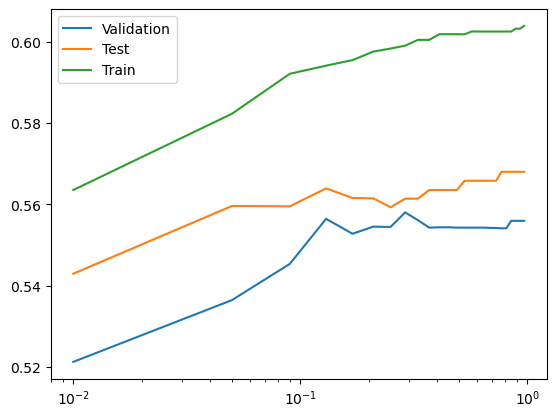

In [29]:
reglist = np.arange(0.01, 1, 0.04).tolist()
auctrain = []
auctest = []
aucval = []
for i in reglist:
    sparsity_param = i
    mod = LogisticRegression(C=sparsity_param, penalty='l1', solver='liblinear').fit(x_train,y_train)

    predicted1 = mod.predict(x_val)
    predicted2 = mod.predict(x_train)
    predicted3 = mod.predict(x_test)
    aucval.append(auc(y_val,predicted1))
    auctrain.append(auc(y_train,predicted2))
    auctest.append(auc(y_test,predicted3))
    print(i)


import matplotlib.pyplot as plt

plt.figure()
plt.semilogx(reglist,aucval,label='Validation')
plt.semilogx(reglist,auctest,label='Test')
plt.semilogx(reglist,auctrain,label='Train')
plt.legend()
plt.show()

Looking at the AUC score for different regularization, it appears the AUC score is the best for both test and validation set at C equals to 10^-0.96. As the AUC score for train set is higher across all C values, we still see overfitting in our model.

For the next parts, we will use C = 0.1096. 

Checks whether the model's predicted probabilities line up with the true probabilities, taking the 10% of rows of the test set with the highest model predictions and compare the mean model predicted probability to the actual mean of the outcome variable. Repeat for the next 10% of rows, and for all 10% groups. Plot to compare the model predicted probabilities on each 10% group to the actual outcomes.

C:\Users\yedot\AppData\Local\Temp\ipykernel_10768\3923088304.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  name1 = pd.Series(pp[a:b].index)
C:\Users\yedot\AppData\Local\Temp\ipykernel_10768\3923088304.py:19: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  avg1 = pp[a:b].mean()
C:\Users\yedot\AppData\Local\Temp\ipykernel_10768\3923088304.py:15: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as 

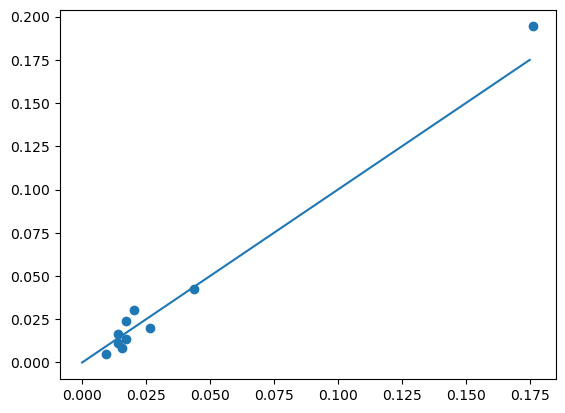

In [30]:
mod = LogisticRegression(C=0.1096, penalty='l1', solver='liblinear').fit(x_train,y_train)
pp = pd.DataFrame(mod.predict_proba(x_test))

pp = pp.sort_values(by=[1],ascending=False)
pp = pp[1]

pp1 = pd.DataFrame(y_test).reset_index(drop=True)

avg_test = []
avg_true = []

for i in range(10):
    a = i * 642
    b = (i+1) * 642 - 1
    name1 = pd.Series(pp[a:b].index)
    pp1name = pd.Series(pp1.index)

    name1 = pp1name[pp1name.isin(name1)]
    avg1 = pp[a:b].mean()
    avg_test.append(avg1)
    tavg1 = pp1.loc[name1].mean()
    avg2 = tavg1[0]
    avg_true.append(avg2)

plt.figure()
plt.scatter(avg_true,avg_test,label=True)
x = np.linspace(0,0.175,100)
y = x
plt.plot(x,y)
plt.show()

Find the fraction of observations which have lower than a 2% model-predicted probability of finding a weapon for white, black, Hispanic, and Asian pedestrians. Stops below this threshold are extremely unlikely to have resulted in finding a weapon, arguably violating the Fourth Amendment. Repeat for 20 thresholds evenly spaced between 1% and 5%. Make a graph where the x-axis is the threshold, and the y-axis is the fraction of stops falling below that threshold, with one line for each race group.

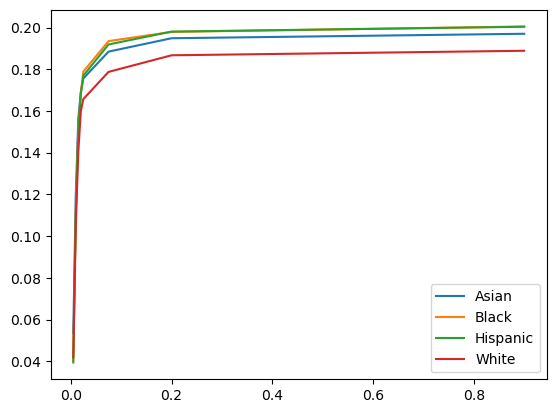

In [36]:
sqf_yr = sqf_yr.reset_index(drop=True)

sqf_yr['lowrisk1'] = pp[pp.le(0.01)]

sqf_yr['lowrisk2'] = pp[pp.le(0.02)]
sqf_yr['lowrisk3'] = pp[pp.le(0.03)]
sqf_yr['lowrisk4'] = pp[pp.le(0.04)]
sqf_yr['lowrisk5'] = pp[pp.le(0.05)]
sqf_yr['lowrisk5.3'] = pp[pp.le(0.15)]
sqf_yr['lowrisk5.5'] = pp[pp.le(0.4)]

sqf_yr['lowrisk6'] = pp[pp.le(0.9)]


racecount = sqf_yr.groupby(['suspect_race']).count()
racecount['lowrisk_search1'] = racecount['lowrisk1'] / racecount['year']


racecount['lowrisk_search2'] = racecount['lowrisk2'] / racecount['year']


racecount['lowrisk_search3'] = racecount['lowrisk3'] / racecount['year']


racecount['lowrisk_search4'] = racecount['lowrisk4'] / racecount['year']


racecount['lowrisk_search5'] = racecount['lowrisk5'] / racecount['year']

racecount['lowrisk_search5.3'] = racecount['lowrisk5.3'] / racecount['year']

racecount['lowrisk_search5.5'] = racecount['lowrisk5.5'] / racecount['year']

racecount['lowrisk_search6'] = racecount['lowrisk6'] / racecount['year']

racecount = racecount[['lowrisk_search1','lowrisk_search2','lowrisk_search3','lowrisk_search4','lowrisk_search5','lowrisk_search5.3','lowrisk_search5.5','lowrisk_search6']]

reglist = [0.005,0.01,0.015,0.02,0.025,0.075,0.2,0.9]
plt.figure()
plt.plot(reglist,racecount.loc['asian'],label='Asian')
plt.plot(reglist,racecount.loc['black'],label='Black')
plt.plot(reglist,racecount.loc['hispanic'],label='Hispanic')
plt.plot(reglist,racecount.loc['white'],label='White')
plt.legend()

plt.show()

The graph shows for all races, as our algorithm suggests higher risk of weapon found, their reaslistic probability of being stopped is also higher. Below the low risk shreshould of 0.02, where we question regard to Fourth Admendment, we see that the white race has the lowest probability of being stopped, showing a significant disparity with the higher level of black and hispanic. For higher risk range over 0.1, we observe a fairly stable level of stop for each race, represented as asian having slightly lower stop rate than black and hispanics, and the rate is significantly lower for white. These are plenty evidence for violation of the Fourth Admendment. 